# Robust nucleation control via crisscross polymerization of highly coordinated DNA slats

Dionis Minev, Christopher M. Wintersinger, Anastasia Ershova, William M. Shih

## Stochastic model simulations for reproducing results used in figure 3G and S30

v6.1 at experimental conditions of 40°C, 20 mM MgCl2, and 1 µM each slat, considering only seed-initiated assembly

### Import dependencies and data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import sem
from scipy.stats import ks_2samp
from scipy.optimize import minimize

In [2]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['lines.markersize'] = 9
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
sns.set_palette('colorblind')

In [3]:
filename = 'TEM_measurements_v6_1_40C_20mM_MgCl2_1uM_slat'
df = pd.read_csv(f'./data/{filename}.csv')

In [4]:
t = [60, 120, 180, 480, 1500]

### Fit model to data

In [5]:
random_seed = 42
seed_num = 150

In [6]:
mean_lengths = [df.mean()[i]/1000 for i in range(len(t))] # in micrometres
sem_lengths = [df.sem()[i]/1000 for i in range(len(t))] # in micrometres
filament_counts = [len(df.iloc[:,i].dropna()) for i in range(len(t))]

In [7]:
p_term_init = 0.0001
growth_rate_init = 2.5
p_stall_init = 0.05

In [8]:
def run_fitting(variables):
    
    timesteps = t[:] # use all data for fitting
    
    # scipy.optimize.minimize uses a step size of 5% - too small for our purposes
    # therefore here I convert a 5% change into a 50% change
    
    p_term,growth_rate,p_stall = variables
    
    p_term = p_term_init-20*(p_term_init-p_term)
    growth_rate = growth_rate_init-20*(growth_rate_init-growth_rate)
    p_stall = p_stall_init-20*(p_stall_init-p_stall)
    
    # avoid negative values due to conversion above
    if p_term < 0: p_term = 0
    if growth_rate < 0: growth_rate = 0
    if p_stall < 0: p_stall = 0
    
    print(p_term,growth_rate,p_stall)
    
    total_filaments = []
    
    for i,step in enumerate(t): # run simulation for all incubation times
            
        if i == 0: # initialise simulation for first timestep
            np.random.seed(random_seed)
            term_filaments = np.array([])
            growing_filaments = np.full(seed_num,0)
            stall_filaments = np.array([])

            prev_step = 0
        
        # perform reaction for length of incubation

        for ts in np.arange(prev_step,step):
            
            recover_inds = []
            for j,filament in enumerate(stall_filaments):
                if np.random.choice([0,1],p=[p_stall,1-p_stall]) == 0: # recover growth of some stalled filaments
                    recover_inds.append(j)
                    growing_filaments = np.append(growing_filaments,stall_filaments[j])
            stall_filaments = np.delete(stall_filaments,recover_inds)

            # grow all filaments
            growing_filaments = growing_filaments + np.full(len(growing_filaments),growth_rate)
            
            term_inds = []
            for j,filament in enumerate(growing_filaments):
                if np.random.choice([0,1],p=[p_term,1-p_term]) == 0: # terminate growth of filaments
                    term_inds.append(j)
                    term_filaments = np.append(term_filaments,growing_filaments[j])
            growing_filaments = np.delete(growing_filaments,term_inds)
            
            term_inds = []
            for j,filament in enumerate(stall_filaments):
                if np.random.choice([0,1],p=[p_term,1-p_term]) == 0: # terminate growth of stalled filaments
                    term_inds.append(j)
                    term_filaments = np.append(term_filaments,stall_filaments[j])
            stall_filaments = np.delete(stall_filaments,term_inds)
            
            stall_inds = []
            for j,filament in enumerate(growing_filaments):
                if np.random.choice([0,1],p=[p_stall,1-p_stall]) == 0: # pause growth of filaments
                    stall_inds.append(j)
                    stall_filaments = np.append(stall_filaments,growing_filaments[j])
            growing_filaments = np.delete(growing_filaments,stall_inds)

        total_filaments.append(np.concatenate((growing_filaments,term_filaments,stall_filaments),axis=None))
        
        prev_step = step

    ks = []

    for i,step in enumerate(timesteps):

        data = df.iloc[:,i].dropna()
        model = total_filaments[i]
        ks.append(ks_2samp(model,data)[0])

    return np.mean(ks)

In [9]:
minim_results = minimize(run_fitting,(p_term_init,growth_rate_init,p_stall_init),
                         method='Nelder-Mead',options={'fatol':0.001})

0.0001 2.5 0.05
0.00019999999999999998 2.5 0.05
0.0001 5.0 0.05
0.0001 2.5 0.10000000000000005
0.000166666666666667 4.166666666666661 2.3592239273284576e-16
0.00011666666666666662 2.9166666666666607 0.07500000000000002
1.1111111111111274e-05 4.444444444444446 0.0666666666666665
0 5.4166666666666785 0.07499999999999975
5.185185185185193e-05 5.740740740740744 0.07777777777777796
0 7.2067901234568055 0.05462962962962971
8.549382716049394e-05 3.9891975308641925 0.06990740740740738
7.921810699588524e-05 3.215020576131682 0.046604938271604904
7.237654320987691e-05 3.8464506172839474 0.0543981481481481
1.2654320987654565e-05 3.1867283950617242 0.07731481481481474
7.816358024691364e-05 4.546682098765427 0.056828703703703756
3.4490740740740925e-05 3.6400462962962976 0.07048611111111099
6.724537037037046e-05 4.320023148148149 0.060243055555555494
0.00013896604938271626 3.6593364197530676 0.056365740740740536
4.307484567901266e-05 4.248167438271597 0.06409143518518508
6.671810699588521e-05 3.7358

In [10]:
# extract parameters from minimisation and rescale

p_term,growth_rate,p_stall = minim_results.x
p_term = p_term_init-20*(p_term_init-p_term)
growth_rate = growth_rate_init-20*(growth_rate_init-growth_rate)
p_stall = p_stall_init-20*(p_stall_init-p_stall)

### Run model for in-between timesteps

In [11]:
def run_model(t,p_term,growth_rate,p_stall,tem=True):
    
    total_filaments = []
    
    for i,step in enumerate(t): # run simulation for all incubation times
            
        if i == 0: # initialise simulation for first timestep
            np.random.seed(random_seed)
            term_filaments = np.array([])
            growing_filaments = np.full(seed_num,0)
            stall_filaments = np.array([])

            prev_step = 0
        
        # perform reaction for length of incubation

        for ts in np.arange(prev_step,step):
            
            recover_inds = []
            for j,filament in enumerate(stall_filaments):
                if np.random.choice([0,1],p=[p_stall,1-p_stall]) == 0: # recover growth of some stalled filaments
                    recover_inds.append(j)
                    growing_filaments = np.append(growing_filaments,stall_filaments[j])
            stall_filaments = np.delete(stall_filaments,recover_inds)

            # grow all filaments
            growing_filaments = growing_filaments + np.full(len(growing_filaments),growth_rate)
            
            term_inds = []
            for j,filament in enumerate(growing_filaments):
                if np.random.choice([0,1],p=[p_term,1-p_term]) == 0: # terminate growth of filaments
                    term_inds.append(j)
                    term_filaments = np.append(term_filaments,growing_filaments[j])
            growing_filaments = np.delete(growing_filaments,term_inds)
            
            term_inds = []
            for j,filament in enumerate(stall_filaments):
                if np.random.choice([0,1],p=[p_term,1-p_term]) == 0: # terminate growth of stalled filaments
                    term_inds.append(j)
                    term_filaments = np.append(term_filaments,stall_filaments[j])
            stall_filaments = np.delete(stall_filaments,term_inds)
            
            stall_inds = []
            for j,filament in enumerate(growing_filaments):
                if np.random.choice([0,1],p=[p_stall,1-p_stall]) == 0: # pause growth of filaments
                    stall_inds.append(j)
                    stall_filaments = np.append(stall_filaments,growing_filaments[j])
            growing_filaments = np.delete(growing_filaments,stall_inds)

        total_filaments.append(np.concatenate((growing_filaments,term_filaments,stall_filaments),axis=None))
        
        prev_step = step
        
    if tem == True:

        ks = []

        for i,step in enumerate(t):

            data = df.iloc[:,i].dropna()
            model = total_filaments[i]
            ks.append(ks_2samp(model,data))

        return total_filaments,ks
    
    else:
        
        return total_filaments

In [12]:
filaments,ks = run_model(t,p_term,growth_rate,p_stall)

### Evaulate fit by comparing CDFs via KS statistic

In [13]:
ks

[Ks_2sampResult(statistic=0.09806451612903226, pvalue=0.419466168804128),
 Ks_2sampResult(statistic=0.12976190476190477, pvalue=0.12405731972348233),
 Ks_2sampResult(statistic=0.07982683982683983, pvalue=0.6759682079941345),
 Ks_2sampResult(statistic=0.3585507246376812, pvalue=2.0856787408263244e-09),
 Ks_2sampResult(statistic=0.13832229580573951, pvalue=0.09352172974849882)]

Text(0.5, 0.98, 'TEM_measurements_v6_1_40C_20mM_MgCl2_1uM_slat')

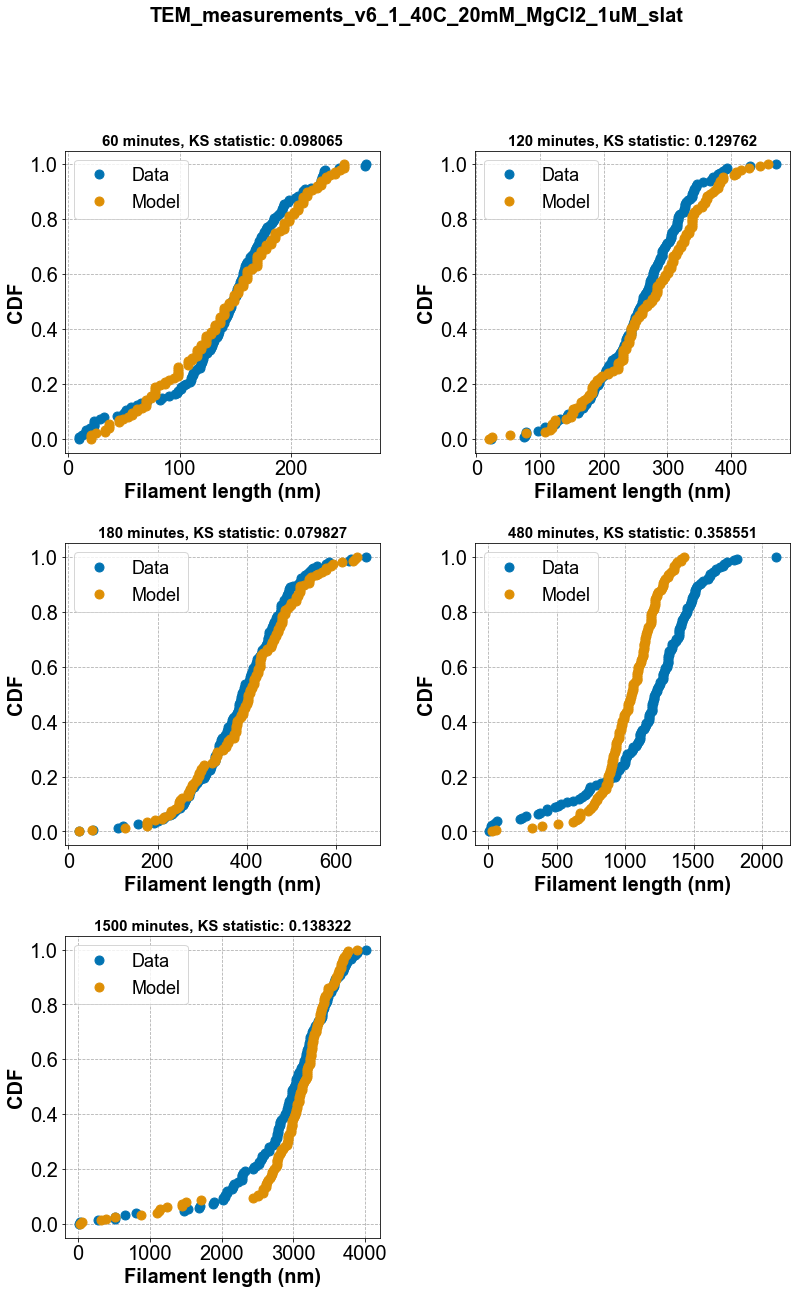

In [14]:
plt.figure(figsize=[13,20])

for i,step in enumerate(t):
    plt.subplot(f'32{i+1}')
    data = df.iloc[:,i].dropna()
    model = filaments[i]
    cdf_data = 1. * np.arange(len(data))/(len(data)-1)
    cdf_model = 1. * np.arange(len(model))/(len(model)-1)
    plt.plot(np.sort(data),cdf_data,'o',label='Data')
    plt.plot(np.sort(model),cdf_model,'o',label='Model')
    plt.ylabel('CDF')
    plt.xlabel('Filament length (nm)')
    plt.title(f'{step} minutes, KS statistic: {np.round(ks[i][0],6)}',fontsize=15)
    plt.legend(loc=2)
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.suptitle(filename)

In [15]:
extended_times = np.linspace(0,2000,251)
extended_filaments = run_model(extended_times,p_term,growth_rate,p_stall,tem=False)

In [16]:
p_term

5.594804543144985e-05

In [17]:
growth_rate

4.1202707883697975

In [18]:
p_stall

0.06276615506500559

### Generate plots for figure S30

In [19]:
bins = [np.linspace(0,max(df.iloc[:,-1])/1000,65),np.linspace(0,max(df.iloc[:,-1])/1000,65),
       np.linspace(0,max(df.iloc[:,-1])/1000,65),np.linspace(0,max(df.iloc[:,-1])/1000,35),
       np.linspace(0,max(df.iloc[:,-1])/1000,20)]

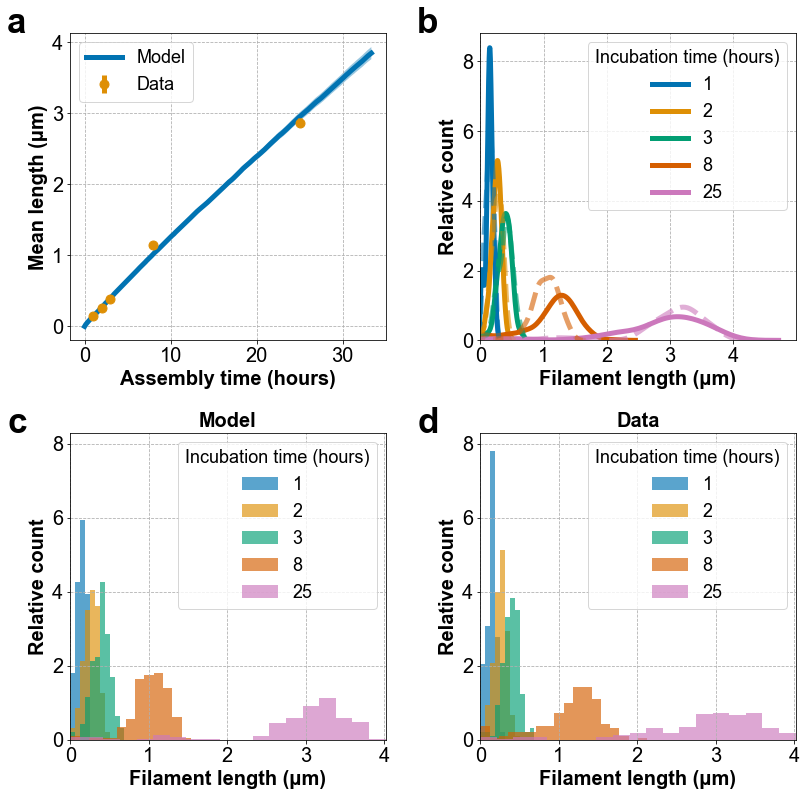

In [20]:
plt.figure(figsize=[13,13])

plt.subplot(221)

model_means = [np.mean(extended_filaments[i])/1000 for i in range(len(extended_times))]
model_sems = [sem(extended_filaments[i])/1000 for i in range(len(extended_times))]
plt.plot(extended_times/60,model_means,'-',label='Model')
plt.fill_between(extended_times/60,np.asarray(model_means)-np.asarray(model_sems),
                 np.array(model_means)+np.array(model_sems),alpha=0.4)
plt.errorbar(np.array(t)/60,mean_lengths,yerr=sem_lengths,fmt='o',label='Data',zorder=3)
plt.legend()
plt.ylabel('Mean length (μm)')
plt.xlabel('Assembly time (hours)')
plt.annotate('a',xy=(-0.2,1),xycoords='axes fraction',fontsize=35,fontweight='bold',annotation_clip=False)

plt.subplot(222)

for i,step in enumerate(t):
    sns.kdeplot(np.array(df.iloc[:,i].dropna())/1000,kernel='gau',ls='-',alpha=1,label=int(step/60))
plt.legend(title='Incubation time (hours)')
plt.gca().set_prop_cycle(None)        
for i,step in enumerate(t):
    sns.kdeplot(np.array(filaments[i])/1000,kernel='gau',ls='--',alpha=0.6)
plt.xlabel('Filament length (μm)')
plt.ylabel('Relative count')
plt.xlim([0,None])
plt.annotate('b',xy=(-0.2,1),xycoords='axes fraction',fontsize=35,fontweight='bold',annotation_clip=False)

plt.subplot(223)
for i,step in enumerate(t):
    sns.distplot(np.array(filaments[i])/1000,kde=False,norm_hist=True,label=int(step/60),hist_kws=dict(alpha=0.65),
                bins=bins[i])
plt.legend(title='Incubation time (hours)')
plt.xlabel('Filament length (μm)')
plt.ylabel('Relative count')
plt.ylim([0,8.3])
plt.xlim([0,max(df.iloc[:,-1])/1000])
plt.title('Model')
plt.annotate('c',xy=(-0.2,1),xycoords='axes fraction',fontsize=35,fontweight='bold',annotation_clip=False)

plt.subplot(224)
for i,step in enumerate(t):
    sns.distplot(np.array(df.iloc[:,i].dropna())/1000,kde=False,norm_hist=True,label=int(step/60),
                 hist_kws=dict(alpha=0.65),bins=bins[i])
plt.legend(title='Incubation time (hours)')
plt.xlabel('Filament length (μm)')
plt.ylabel('Relative count')
plt.ylim([0,8.3])
plt.xlim([0,max(df.iloc[:,-1])/1000])
plt.title('Data')
plt.annotate('d',xy=(-0.2,1),xycoords='axes fraction',fontsize=35,fontweight='bold',annotation_clip=False)

plt.subplots_adjust(hspace=0.3,wspace=0.3)